# AutoML solution vs single model
#### FEDOT version = 0.7.2

In [1]:
!pip install fedot==0.7.2

Note: you may need to restart the kernel to use updated packages.


Below is an example of running an Auto ML solution for a classification problem.
## Description of the task and dataset

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import logging
logging.raiseExceptions = False

# Input data from csv files 
train_data_path = '../data/scoring_train.csv'
test_data_path = '../data/scoring_test.csv'
df = pd.read_csv(train_data_path)
df.head(5)

,ID,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30.59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60.89DaysPastDueNotWorse,NumberOfDependents,target
0,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0


## Baseline model

Let's use the api features to solve the classification problem. First, we create a pipeline with a single model "xgboost". 
To do this, we will substitute the appropriate name in the predefined_model field.

Attention!
"predefined_model" - is not an initial assumption for the AutoML algorithm. It's just a single model without AutoML part

In [3]:
from fedot.api.main import Fedot

# task selection, initialisation of the framework
baseline_model = Fedot(problem='classification')

# fit model without optimisation - single XGBoost node is used 
xgb_pipeline = baseline_model.fit(features=train_data_path, target='target', predefined_model='xgboost')

# evaluate the prediction with test data
xgb_predict = baseline_model.predict_proba(features=test_data_path)

2023-10-02 19:07:00,226 - CSV data extraction - Used the column as index: "ID".
2023-10-02 19:07:10,038 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [xgboost]}
xgboost - {'eval_metric': 'mlogloss', 'nthread': -1}
2023-10-02 19:07:10,041 - MemoryAnalytics - Memory consumption for finish in main session: current 35.9 MiB, max: 63.5 MiB
2023-10-02 19:07:10,114 - CSV data extraction - Used the column as index: "ID".


In [4]:
from fedot.core.data.data import InputData
from sklearn.metrics import roc_auc_score

# Read data from csv file as InputData
test_data = InputData.from_csv(test_data_path)
roc_auc_baseline = roc_auc_score(test_data.target, xgb_predict)
roc_auc_baseline

2023-10-02 19:07:10,321 - CSV data extraction - Used the column as index: "ID".


0.8332360242279814

## FEDOT AutoML for classification

We can identify the model using an evolutionary algorithm built into the core of the FEDOT framework.

Here are some parameters that you can specify when initializing a class:
* problem - the name of modelling problem to solve:
        - classification
        - regression
        - ts_forecasting
        - clustering
* seed - value for fixed random seed
* logging_level - level of the output detailing
        - 50 -> critical
        - 40 -> error
        - 30 -> warning
        - 20 -> info
        - 10 -> debug
        - 0 -> nonset
* timeout - time for model design (in minutes)

In [5]:
# new instance to be used as AutoML tool
auto_model = Fedot(problem='classification', seed=42, logging_level=10, timeout=5)

In [6]:
# run of the AutoML-based model generation
pipeline = auto_model.fit(features=train_data_path, target='target')

2023-10-02 19:07:10,443 - CSV data extraction - Used the column as index: "ID".


2023-10-02 19:07:12,402 - AssumptionsHandler - Initial pipeline fitting started
2023-10-02 19:07:13,459 - PipelineNode - Trying to fit pipeline node with operation: rf
2023-10-02 19:07:13,461 - PipelineNode - Fit all parent nodes in secondary node with operation: rf
2023-10-02 19:07:13,463 - PipelineNode - Trying to fit pipeline node with operation: scaling
2023-10-02 19:07:17,885 - PipelineNode - Obtain prediction in pipeline node by operation: rf
2023-10-02 19:07:17,886 - PipelineNode - Fit all parent nodes in secondary node with operation: rf
2023-10-02 19:07:17,890 - PipelineNode - Obtain prediction in pipeline node by operation: scaling
2023-10-02 19:07:17,973 - AssumptionsHandler - Initial pipeline was fitted successfully
2023-10-02 19:07:17,975 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 11.6 MiB, max: 41.9 MiB
2023-10-02 19:07:17,978 - ApiComposer - Initial pipeline was fitted in 5.6 sec.
2023-10-02 19:07:17,979 - Assum

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-10-02 19:07:18,021 - MultiprocessingDispatcher - Number of used CPU's: 8
2023-10-02 19:08:12,284 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2023-10-02 19:08:12,369 - EvoGraphOptimizer - Generation num: 1 size: 3
2023-10-02 19:08:12,372 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.848 node_number=0.200>']
2023-10-02 19:08:12,400 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002104EDBAB80> on graph=(/n_scaling;)/n_catboost_{'allow_writing_files': False, 'verbose': False}.
2023-10-02 19:08:12,438 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Current pipeline can not solve multitask problem> for rule=<function has_no_conflicts_during_multitask at 0x000002104EDBAB80> on graph=(/n_scaling;)

Generations:   0%|          | 1/10000 [08:45<?, ?gen/s]

2023-10-02 19:16:03,163 - OptimisationTimer - Composition time: 8.752 min
2023-10-02 19:16:03,164 - OptimisationTimer - Algorithm was terminated due to processing time limit
2023-10-02 19:16:03,169 - EvoGraphOptimizer - Generation num: 4 size: 1
2023-10-02 19:16:03,171 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.848 node_number=0.100>']
2023-10-02 19:16:03,172 - EvoGraphOptimizer - no improvements for 2 iterations
2023-10-02 19:16:03,173 - EvoGraphOptimizer - spent time: 8.8 min
2023-10-02 19:16:03,176 - GPComposer - GP composition finished
2023-10-02 19:16:03,272 - ApiComposer - Model generation finished


2023-10-02 19:16:04,977 - PipelineNode - Trying to fit pipeline node with operation: catboost
2023-10-02 19:16:15,449 - FEDOT logger - Final pipeline was fitted
2023-10-02 19:16:15,451 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [catboost]}
catboost - {'allow_writing_files': False, 'verbose': False}
2023-10-02 19:16:15,452 - MemoryAnalytics - Memory consumption for finish in main session: current 17.2 MiB, max: 45.0 MiB


In [7]:
prediction = auto_model.predict_proba(features=test_data_path)

# Calculate metric
roc_auc_auto = roc_auc_score(test_data.target, prediction)

2023-10-02 19:16:15,500 - CSV data extraction - Used the column as index: "ID".
2023-10-02 19:16:15,709 - PipelineNode - Obtain prediction in pipeline node by operation: catboost


Let see  at the pipeline.

2023-10-02 19:16:15,899 - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-10-02 19:16:15,903 - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-10-02 19:16:15,908 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-10-02 19:16:15,911 - findfont: score(FontEntry(fname='d:\\anaconda_envs\\.conda\\envs\\examples\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-10-02 19:16:15,913 - findfont: score(FontEntry(fname='d:\\anaconda_envs\\.conda\\envs\\examples\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2023-10-02 19:16:15,914 - findfont: score(FontEntry(fname='d:\\anaconda_envs\\.conda\\en

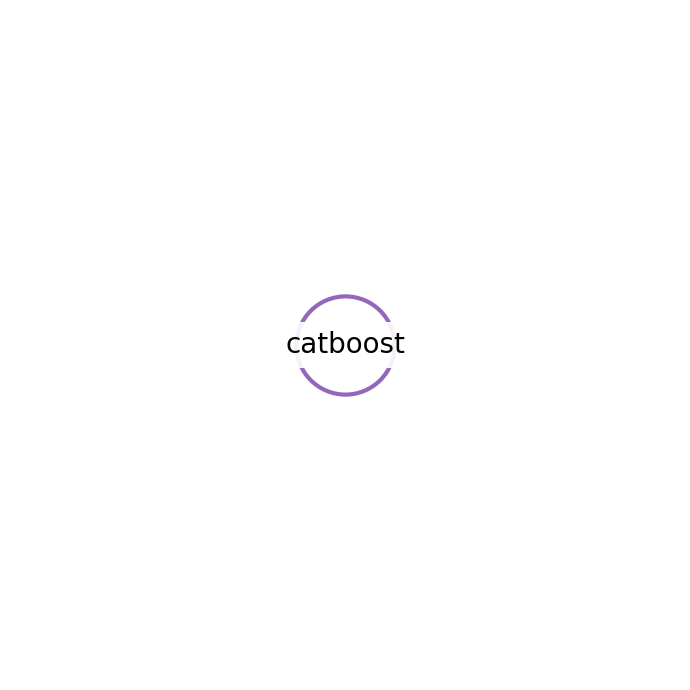

In [8]:
pipeline.show()

In [9]:
# comparison with the manual pipeline

print(f'Baseline {roc_auc_baseline:.2f}')
print(f'AutoML solution {roc_auc_auto:.2f}')

Baseline 0.83
AutoML solution 0.85


Thus, with just a few lines of code, we were able to launch the FEDOT framework and got a better result*.

*Due to the stochastic nature of the algorithm, the metrics for the found solution may differ.

If you want to learn more about FEDOT, you can use [this notebook](2_intro_to_fedot.ipynb).